# **CSCI 1951A NLP & Matrix Factorization Lab**

## What is Matrix Factorization?

Matrix Factorization, also known as Matrix Decomposition, is essentially writing a matrix A as the product of some number of matrices. 

Matrix factorization is used in and for many different things, including latent semantic analysis (LSA), recommender systems, dimensionality reduction, and more. One of the main motivations behind using matrix factorization is that it finds the latent features of whatever data is being analyzed, giving us a tool for finding the associations each datapoint has with those latent features to rank or categorize information.

For example, if we were looking at people and movie ratings they gave, we could split our original people-movie matrix into people-features and movie-features matrices, where either a person or a movie is associated with different values/weights for each feature. If humor is a latent feature, then each person will have some weight for how much humor affects their rating of a movie, and similarly, each movie will have a weight for how much it is associated with humor.

![alt text](https://miro.medium.com/max/3378/1*Zhm1NMlmVywn0G18w3exog.png)

A famous use of matrix factorization is in the [Netflix Challenge](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf), where it is used to draw conclusions about how people would rate movies that they haven't seen. In recommender systems in general, matrix factorization is used to find relationships between users and features so that we can use the information given by other users and generalize this to draw conclusions about users for whom we don’t have the same information (recommending new things to people based on other people’s reviews).


## How do we do Matrix Factorization?

There are many ways of factorizing a matrix. Some common ways include LU Decomposition, QR Decomposition, Cholesky Decomposition, Singular Value Decomposition and Eigenvalue Decomposition. In this lab, we will be focusing mainly on SVD (as covered in class).

**An important note**: Principal Component Analaysis, or Truncated SVD, are not exactly matrix factorization - it is a data analysis method to reduce the dimensionality of your data, and they only happen **after** you have performed your matrix factorization, using some matrix factorization methods such as Singular Value. To intuitively understand the difference between PCA and SVD, [read here](https://www.quora.com/What-is-the-difference-between-PCA-and-SVD).

### Checkpoint 1:

Be sure to know the difference between matrix factorization methods (e.g., Singular Value Decomposition) and dimensionality reduction methods (e.g., Principal Component Analysis, Truncated SVD)

# Topic Modeling - Latent Semantic Analysis

In this lab, we will introduce the concept of dimensionality reduction using a Natural Language Processing application: topic modeling. Topic modeling allows us to classify a text document into a certain topic. To give a concrete example, consider this piece of text:

> *It is called high-definition - HD for short - and it is already hugely popular in Japan and the US. It is set, according to analysts, to do for images what CDs did for sound. Different equipment able to receive HD signals is needed though and is expensive. But Europe's gamers may be the early adopters to drive demand. Europeans will have to wait until at least 2006 until they see mainstream HDTV.*

If asked what this piece of text is about, you may say it's about TVs or technology but not about food or fashion. This is in essence the heart of what we are trying to do in topic modeling.

We will group documents from a corpus of BBC (British Broadcasting Corporation) news articles into 3 of 100 different possible topics each. Specifically, from the `n` possible topics (that correspond to the number of all the possible words that appear in all the texts), we will use Truncated Singular Value Decomposition to limit it down to 100 topics. From there, for each document, we will figure out what the top 3 topics that would describe the document are, out of the 100 topics that we have limited the space down to.

**Note**: Keep in mind that we specify that our model should generate 100 topics, but since computers don’t have an innate understanding of language, there’s no easy way for us to specify what these 100 topics should be. The model will instead figure out 100 general categories that the words fall under, and looking at the words in each category can give you a sense of what each topic might be. There’s no way for us to truly know what each topic represents, however. In other words, instead of giving us concrete topics like “sports” and “animals,” we just end up with 100 abstract topics: topic0, topic1, …, topic 99. This is a downside of dimensionality reduction: We know that each variable in the reduced matrix are linearly independent from one another, and are the most important ones, but we can't really explain in words what the topics are in human language.



### Converting the documents into matrices

First, we need to convert natural language documents into arrays that will explain what the document is about. One common way is to represent each document as a matrix of *term frequency-inverse document frequency* scores, as known as tf-idf scores.

Consider `k` documents, where all the `k` documents used a pool of `n` possible words. Then, each document's tf-idf matrix is going to be a list of `n` elements, and after combining the `k` different tf-idf representations together, we will have a `(k, n)` matrix. We will talk about what the tf-idf score that will go inside each cell `(i, j)` soon! But for now, we need to do some document processing work to get to that stage.



#### Data Cleaning

Text data usually requires more preprocessing than numerical data. This section will outline several techniques used to process text. Even though there are many steps, the NLTK (Natural Language Toolkit) library thankfully does most of the work for us.

For this part of the assignment, you'll be filling out a function called `process_document` which performs the following operations on a document:

**Consistent casing**: When dealing with text data, it’s important to convert our text to either all lower case or all upper case (though typically lower cased is used for legibility). This is to ensure that we don’t mistakenly treat two words with different casing but with the same characters as distinct. For instance, we want to treat “Data”, "DATA", and “data” all as the same word, which we can do by converting all of our text to lower case.

**Tokenization**: Tokenization refers to the act of breaking up a document into discrete words. This is more complicated than simply splitting on all whitespace: If we just split on whitespace, then the document (with all words converted to lower case) “i like to sleep. sleep is good.” won’t be tokenized correctly since “sleep.” and “sleep” will be treated as two distinct words.

There are many other edge cases that can come up during tokenization. NLTK comes with tokenizers that we can use, but we’ll be using the `RegexpTokenizer` to remove any non-alphanumeric characters, such as punctuation and whitespace.

**Removing Common Words**: When working with text data, we oftentimes want to remove common words that don’t contribute much to the meaning of sentences such as *“the”* and *“is”*. These words are referred to as *stop words*.

This is especially important for topic modeling, which relies on using word frequencies to generate the topics (more on this later). Since stop words appear so often, if we didn’t remove them, all of our topics may be determined by stop words, which isn’t helpful since these words don’t have much semantic meaning and typically aren’t specific to a certain topic.

**Stemming**: Consider words like “warmer” and “warmest.” Even though they’re technically distinct words, they share a common root: “warm”, so it makes sense to consider them all the same in NLP. This process of removing word suffixes is referred to as stemming. Just like with tokenization, NLTK comes with [built-in stemmers](http://www.nltk.org/howto/stem.html). For this assignment, we’ll be using the `
SnowballStemmer`, which algorithmically removes word suffixes based on orthography (spelling).

In [ ]:
import nltk, ssl
try:
  nltk.data.find('corpora/stopwords')
except LookupError:
  try:
    _create_unverified_https_context = ssl._create_unverified_context
  except AttributeError:
    pass
  else:
    ssl._create_default_https_context = _create_unverified_https_context
  nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def process_document(text):
  """
  Processes a text document by coverting all words to lower case,
  tokenizing, removing all non-alphabetical characters,
  and stemming each word.
  
  Input:
  - text: A string of the text of a single document.
  
  Returns:
  - A list of processed words from the document.
	"""
  # Convert words to lower case
  text = text.lower()
  # text = ???
  
  # TODO: Tokenize document and remove all non-alphanumeric characters
  
  # First, create an NLTK's RegexpTokenizer object. Hint: You may want to pass
  # in r'\w+' as an argument to your RegexpTokenizer!
  tokenizer = RegexpTokenizer(r'\w+')
  # tokenizer = ???
  # Second, use the tokenizer that you just created to tokenize the text!
  
  # text = ???
  text = tokenizer.tokenize(text)
  
  # TODO: Remove stopwords
  # First, we get the list of English stopwords from NLTK!
  stop_words = stopwords.words('english')
  
  # Second, we will redefine text, so that now text only contains the words
  # that are not in our list of stopwords (stop_words)
  text = [word for word in text if word not in stop_words]
  # text = ???
  
  # TODO: Stem words
  # First, we need to create an English SnowballStemmer from NLTK
  stemmer = SnowballStemmer('english')
  
  # Then, we will stem each word in the `text` list of words that we have
  text = [stemmer.stem(word) for word in text]
  # text = ???
  
  # Return list of processed words
  return text


assert process_document("I love Natural Language Processing.") == ["love", \
                                                  "natur", "languag", "process"]
assert process_document("Professor Pavlick is my QUEEN!!") == ["professor", \
                                                  "pavlick", "queen"]
assert process_document("Kishi Bashi is SO GOOD ugh lmao") == ["kishi", "bashi",\
                                                  "good", "ugh", "lmao"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Documents to necessary data structures!

Alright. Now given the written `process_document` function, we can now read in each of our documents. For each document, we want to come up with the following information that is necessary to come up with our tf-idf representations:

- A bag of words of each document. For example, if we had this document:

  > Zeke likes maps a lot. Ellie likes computers a little.

  Our bag of words would look like this:

  ```
  {
    'Zeke': 1,
    'likes': 2,
    'maps':, 1,
    'a': 2,
    'lot': 1,
    'Ellie': 1,
    'computers': 1,
    'little': 2
  }
  ```
- A mapping from each word to the number of documents that it appears in (and not the total number of times each word appear across all documents).
- A mapping from words to their unique integer IDs (this is so that we can have a numeric idenitifer of the words)

Additionally, after we have identified the top 3 important topics for each document, we may want to train a classification model to see if we can classify what the document is about using their top 3 topics. Therefore, as part of populating the document information to necessary data structures, we want to also include this piece of information:

- A mapping from each document to their labels (e.g. `e`, `p`, `t`, `s`, or `b`, for `entertainment`, `politics`, `technology`, `sports`, or `business`, respectively).

For this part, we have written the code for you. Print out what the returns look like so you have a good idea of the information that we have access to so far in the pipeline!

First, we will take a look at what our data looks like by taking a look at the first five items in our data (with each item being of the format `[document_content, document_tag]`)

In [ ]:
import json
import requests

DATA_URL = "https://cs1951a-summer2021-brown.github.io/assignments/labs/matrix_factorization/data/bbc_data.json"
data = requests.get(DATA_URL).json()

data[:5]

[['Cash gives way to flexible friend\n\nSpending on credit and debit cards has overtaken cash spending in the UK for the first time.\n\nThe moment that plastic finally toppled cash happened at 10.38am on Wednesday, according to the Association for Payment Clearing Services (Apacs) Apacs chose school teacher Helen Carroll, from Portsmouth, to make the historic transaction. The switch over took place as she paid for her groceries in the supermarket chain Tesco\'s Cromwell Road branch.\n\nMrs Carroll was born in the same year that plastic cards first appeared in the UK. "I pay for most things with my debit card, with occasional purchases on one of my credit cards," said Mrs Carroll, who teaches at Peel Common Infants School in Gosport.\n\nSpending patterns for the year and estimates for December led Apacs to conclude that 10.38am was the time that plastic would finally rule the roost. Shoppers in the UK are expected to put £269bn on plastic cards during the whole of 2004, compared with £2

Now that we have successfully loaded our data into the variable `data`, we will run our data through the function `documents_to_data_structures` to get the four data structures that we need for tf_idf

In [ ]:
from collections import Counter

def documents_to_data_structures(input_data):
  """
  Preprocess all the text documents to output the necessary data structures
  for TF-IDF matrix calculation and for classification algorithms.
  
  Input:
  - input_data: A list of lists, where each list is of the form:
            [content, document_label]
    e.g.: [["The case for lentiviral gene therapy's head-to-tooe reach", "t"],
          ["Kathryn Garcia could win the NYC Democratic mayoral primary", "p"]]
  Outputs (in the exact order):
    1. A mapping from zero-index document IDs to a bag of words (mapping from
    word to the number of times it appears)
    2. A mapping from words to the number of documents it appears in
    3. A mapping from words to unique, zero-indexed integer IDs
    4. A mapping from document IDs to labels
  """
  documents = {} # Mapping from document IDs to a bag of words
  document_word_counts = Counter() # Mapping from words to # of documents its in
  word_ids = {} # Mapping from words to unique integer IDs
  labels = {} # Mapping from document IDs to labels

  document_index, word_index = 0, 0

  for content, document_label in input_data:
    bag_of_words = Counter() # data structure for the document's bag of words
    encountered_words = set() # keep track of the words we've seen

    # break down the document into a list of words using our previously defined
    # process_document function
    doc = process_document(content)

    # loop through each word in the processed document:
    for word in doc:
      # increment the count of that word in the bag of words
      bag_of_words[word] += 1

      # check if the word is associated with an id or not
      if word not in word_ids:
        # if so, we will assign that word to a new word_index,
        # and increment the word_index for the next novel word
        word_ids[word] = word_index
        word_index += 1
      
      # check if we have seen this word in this document or not -
      # this is to make sure that we only update document_word_counts once
      # per word in this document
      if word not in encountered_words:
        document_word_counts[word] += 1
        encountered_words.add(word)

    # alright. after having finished processing all the words in the document,
    # we will assign the bag of words to this specific document index, and let
    # the label dictionary knows about the label of this document
    documents[document_index] = bag_of_words
    labels[document_index] = document_label

    # and then increment the document index to move on to the next document
    document_index += 1

  # once we've finished processing through all the documents, we'll return the
  # four data structures that we've been calculating
  return documents, document_word_counts, word_ids, labels


# run our function! 
docs, word_to_doccounts, word_to_ids, doc_to_labels = \
                                              documents_to_data_structures(data)

And now, let's take a look at five random elements for each of the data structures that we have created above!

In [ ]:
docs_randkeys, word_to_doccounts_randkeys, word_to_ids_randkeys, doc_to_labels_randkeys = \
  list(docs.keys())[:5], list(word_to_doccounts.keys())[:5], list(word_to_ids.keys())[:5], list(doc_to_labels.keys())[:5]

print("docs sample: ", {k: docs[k] for k in docs_randkeys})
print("word_to_doccounts sample: ", {k: word_to_doccounts[k] for k in word_to_doccounts_randkeys})
print("word_to_ids sample: ", {k: word_to_ids[k] for k in word_to_ids_randkeys})
print("doc_to_labels sample: ", {k: doc_to_labels[k] for k in doc_to_labels_randkeys})

docs sample:  {0: Counter({'card': 8, 'plastic': 7, 'apac': 5, 'cash': 4, 'uk': 4, 'spend': 3, 'debit': 3, 'first': 3, 'carrol': 3, 'year': 3, 'said': 3, 'way': 2, 'flexibl': 2, 'credit': 2, 'time': 2, 'final': 2, '10': 2, '38am': 2, 'school': 2, 'transact': 2, 'paid': 2, 'mrs': 2, 'appear': 2, 'pay': 2, 'give': 1, 'friend': 1, 'overtaken': 1, 'moment': 1, 'toppl': 1, 'happen': 1, 'wednesday': 1, 'accord': 1, 'associ': 1, 'payment': 1, 'clear': 1, 'servic': 1, 'chose': 1, 'teacher': 1, 'helen': 1, 'portsmouth': 1, 'make': 1, 'histor': 1, 'switch': 1, 'took': 1, 'place': 1, 'groceri': 1, 'supermarket': 1, 'chain': 1, 'tesco': 1, 'cromwel': 1, 'road': 1, 'branch': 1, 'born': 1, 'thing': 1, 'occasion': 1, 'purchas': 1, 'one': 1, 'teach': 1, 'peel': 1, 'common': 1, 'infant': 1, 'gosport': 1, 'pattern': 1, 'estim': 1, 'decemb': 1, 'led': 1, 'conclud': 1, 'would': 1, 'rule': 1, 'roost': 1, 'shopper': 1, 'expect': 1, 'put': 1, '269bn': 1, 'whole': 1, '2004': 1, 'compar': 1, '268bn': 1, 'june'

Alright, onto the most exciting part of all!

#### TF-IDF Matrix Calculation

As we have mentioned above, our goal is to represent each document as a tf-idf array. Let's first write the function to calculate the tf-idf representation for each document!

Each of the `n` tf-idf scores that make up the tf-idf representation is composed of two parts: the term frequency (tf) score, and the inverse document frequency (idf) score. More specifically:
- Given a word `i` in a document `X`, the tf score for the word `i` is equal to the number of times the word `i` appears in document `X`, **divided by** the total number of words in document `X`.
- Still looking at the word `i`, the idf score is calculated by first dividing the total number of documents in our corpora by the number of unique documents that the word `i` appears in, and then taking the **natural log** of that division.
- After we have calculated the tf and the idf scores of the word `i` in the document `X`, the tf-idf score is calculated by multiplying the tf and idf scores together.

Let's get down to writing the function to calculate the tf-idf representation of a document!

In [ ]:
import numpy as np

# The number of distinct words that we see across all the documents we're
# working with
NUM_DISTINCT_WORDS = len(word_to_ids)

# The number of distinct documents in our corpora
NUM_DISTINCT_DOCUMENTS = len(docs)

def document_to_tfidf(document_bow):
  """
  Function to calculate a document's tf-idf representation!
  
  Input:
  - document_bow: A dictionary (or Counter object) that contains the mapping
                  from a word to the number of times that the word appears in
                  the document!
  Output:
  - tfidf_rep: The tf-idf representation of the document! The size should be
              a 1D numpy array of length (n), where n is the number of distinct
              words that we see across all the documents that we're working with
  """
  # initialize the tfidf representation to be (n) zeros first, since we haven't
  # processed any words in the document that we're looking at right now
  tfidf_rep = np.zeros(NUM_DISTINCT_WORDS)
  # tfidf_rep = ???

  # for each word in the document, since we know that the word appears in the
  # document, we will get the index of the tfidf_rep that corresponds to the
  # word, and change the tfidf score associated with that word accordingly
  for word in document_bow:
    ##### tf score calculation!!! #####
    # First, get the index of this word (word_id)
    # word_id = ???
    word_id = word_to_ids[word]

    # Second, get the number of times that this word appears in the document
    # numoccurences_word_this_doc = ???
    numoccurences_word_this_doc = document_bow[word]
    
    # And calculate the tf score! (tf: num times word appears in this doc, divided
    #           by the number of words in this document)
    # tf = ???
    tf = numoccurences_word_this_doc / sum(document_bow.values())

    ##### Alright. Now moving on to the idf score! #####
    # First, get the number of distinct documents that <word> appears in!
    # numoccurences_word_alldocs = ???
    numoccurences_word_alldocs = word_to_doccounts[word]

    # Then, we will calculate the idf score (idf: natural log of (the total num
    # of documents divided by the number of distinct document that <word> occurs
    # in)) HINT: Look up np.log() function!
    # idf = ???
    idf = np.log(NUM_DISTINCT_DOCUMENTS / numoccurences_word_alldocs)

    ##### Lastly, calculate the tf-idf score, and update the representation #####
    # tfidf_score = ???
    tfidf_score = tf*idf

    # tfidf_rep[???] = tfidf_score
    tfidf_rep[word_id] = tfidf_score

  # and then return the representation!
  return tfidf_rep


# Try running it on the document with id 0!
tfidf_0 = document_to_tfidf(docs[0])
print("TF-IDF representation of Document 0: ", tfidf_0)
print("Shape of TF-IDF of represenation of Document 0: ", tfidf_0.shape)

TF-IDF representation of Document 0:  [0.07438769 0.0109197  0.01653178 ... 0.         0.         0.        ]
Shape of TF-IDF of represenation of Document 0:  (20418,)


Alright. To check if you have written the tf-idf representation function correctly, run this piece of code!

In [ ]:
FIRST_REP_URL = "https://cs1951a-summer2021-brown.github.io/assignments/labs/matrix_factorization/data/first_representation.json"
tfidf_0_res = np.array(requests.get(FIRST_REP_URL).json())

# This is to assert that what you have calculated above is close to our result!
assert np.all(np.isclose(tfidf_0, tfidf_0_res))

Alright. Now that we have written the function to calculate the tf-idf representation of each document, we will run the piece of code below to apply
your `document_to_tfidf` function to all our documents! The resulting tf_idf matrix will be a `k x n` matrix, where `k` represents the number of documents and `n` represents the dimensionality of each `tf-idf` representation!

In [ ]:
all_tfidf_representations = np.zeros((NUM_DISTINCT_DOCUMENTS, NUM_DISTINCT_WORDS))
for i in range(NUM_DISTINCT_DOCUMENTS):
  # each row i is associated with a document. get the document i's bag of words,
  # and change the row i of all_tfidf_representations to that document's tfidf rep
  all_tfidf_representations[i][:] = document_to_tfidf(docs[i])

# alright, now print out the resulting all_tfidf_representations!
print("all documents tf-idf matrix: ", all_tfidf_representations)
print("all documents tf-idf matrix shape: ", all_tfidf_representations.shape)

all documents tf-idf matrix:  [[0.07438769 0.0109197  0.01653178 ... 0.         0.         0.        ]
 [0.         0.         0.0147471  ... 0.         0.         0.        ]
 [0.         0.01242314 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00480222 0.00363514 ... 0.         0.         0.        ]]
all documents tf-idf matrix shape:  (4115, 20418)


Woah, that was a loot of code action going on! You can read more about the tf-idf scores in this link: [https://monkeylearn.com/blog/what-is-tf-idf/](https://monkeylearn.com/blog/what-is-tf-idf/).

#### Checkpoint 2:

Be sure to understand the following concepts:
- What are the steps to clean textual data? Why do we want to follow those steps?
- What is tf-idf? Why do we want to use tf-idf to represent what the topics of a document are?

### Matrix Factorization & Dimensionality Reduction!

Given the `k x n` matrix above, we want to reduce the dimensionality of our matrix to be `k x 100` (`k` documents, `100` features) to figure out what our dimensionality reduction algorithm determines to be the top `100` most important topics to explain our `k` documents. From there, for each document, we will find which 3 of the top 100 topics can best explain that document!

Think about this parallel: Consider a pool of `k` students, and you are trying to evaluate which 3 things are each student the best at. However, there are `n` possible things that all `k` students can do, and so trying to evaluate all `k` students on `n` things will produce a lot of noise (since each student will only know like a very very small fraction of the `n` things). Therefore, we are trying to use Matrix Factorization & Dimensionality Reduction to determine the top `100` things to evaluate the `k` students based on, and then we will move on to evaluate each student: Student A is good at skills `[0, 7, 14]`, Student B is good at skills `[0, 16, 36]`, etc.

In this part of the assignment, we are going to experiment with two different dimensionality reduction methods: Principal Component Analysis, and Truncated Singular Value Decomposition. If you are interested in learning the difference between these two methods, [read here](https://stats.stackexchange.com/questions/239481/difference-between-scikit-learn-implementations-of-pca-and-truncatedsvd). The most importance piece of information is that: TruncatedSVD works well with sparse matrices (those with many zero values) as it doesn't center the data, whereas PCA performs poorly on sparse matrices as the runtime will explode trying to center the data.

Let's dive into it! Read the documentation for [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) and [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to create the `TruncatedSVD` and `PCA` objects that will reduce our data to `100` features! (i.e., `n_components = 100`). Remember to make your `random_state=0`!

In [ ]:
from sklearn.decomposition import TruncatedSVD, PCA

NUM_COMPONENTS = 100

my_truncatedsvd = TruncatedSVD(n_components=NUM_COMPONENTS, random_state=0)
my_pca = PCA(n_components=NUM_COMPONENTS, random_state=0)
# my_truncatedsvd = ???
# my_pca = ???

Now, we will use the `my_truncatedsvd` and `my_pca` objects to reduce the dimensionality of your tf-idf matrix `all_tfidf_representations` ! Currently, it should be of dimension `(k, n) = (4115, 20418)`, and we want to fit and then transform the matrix to reduce the dimensionality down to `(4115, 100)`!

In [ ]:
tsvd_reduced = my_truncatedsvd.fit_transform(all_tfidf_representations)
pca_reduced = my_pca.fit_transform(all_tfidf_representations)

# tsvd_reduced = ???
# pca_reduced = ???

print("Shape of the matrix reduced by TruncatedSVD: ", tsvd_reduced.shape)
print("Shape of the matrix reduced by PCA: ", pca_reduced.shape)
assert tsvd_reduced.shape == (4115, 100)
assert pca_reduced.shape == (4115, 100)

Shape of the matrix reduced by TruncatedSVD:  (4115, 100)
Shape of the matrix reduced by PCA:  (4115, 100)


Now, for each of the reduced matrices (`tsvd_reduced` and `pca_reduced`), we want to explore the question: for each of the document (each row), which three features (out of the 100 that we have reduced the original matrix down to) are the most important?

We have written the function `identify_top_three` below, which takes in either `tsvd_reduced` or `pca_reduced`, and outputs a dictionary where each key is a document ID and the value would be the three **indices** of features that best explain the document ID of interest.

Use the function `identify_top_three` on both `tsv_reduced` and `pca_reduced` to get the top three topics for each document, identified by our two dimensionality reduction methods of interest!

In [ ]:
TOPICS_PER_DOCUMENT = 3

def identify_top_three(input_matrix):
  """
  input: - numpy array, dim (x, k) (probably (4115, 100))
  func: identify the top 3 most important features out of 100 for each row
  output: - numpy array, dimensionality (x, 3) (probably (4115, 3))
  """
  return_matrix = np.zeros((input_matrix.shape[0], TOPICS_PER_DOCUMENT))
  # for each row
  for i in range(input_matrix.shape[0]):
    # we will get the top three most important indices
    return_matrix[i] = input_matrix[i].argsort()[-TOPICS_PER_DOCUMENT:]
  return return_matrix


top_threes_tsvd = identify_top_three(tsvd_reduced)
top_threes_pca = identify_top_three(pca_reduced)

print("Shape of the TruncatedSVD Top 3 Matrix: ", top_threes_tsvd.shape)
print("Shape of the PCA Top 3 Matrix: ", top_threes_pca.shape)

assert top_threes_tsvd.shape == top_threes_pca.shape == (4115, 3)

print("TruncatedSVD Top 3 Matrix: ", top_threes_tsvd)
print("PCA Top 3 Matrix: ", top_threes_pca)

Shape of the TruncatedSVD Top 3 Matrix:  (4115, 3)
Shape of the PCA Top 3 Matrix:  (4115, 3)
TruncatedSVD Top 3 Matrix:  [[73. 71.  0.]
 [ 1.  0. 14.]
 [25.  1.  0.]
 ...
 [22. 23.  0.]
 [ 0. 17. 18.]
 [69. 15.  0.]]
PCA Top 3 Matrix:  [[31. 84. 72.]
 [11.  0. 13.]
 [ 5. 24.  0.]
 ...
 [22. 28. 38.]
 [21. 16. 17.]
 [15. 14. 68.]]


Woohoo! Now, we will evaluate how well our TruncatedSVD Top 3 Matrix (`top_threes_tsvd`) and PCA Top 3 Matrix (`top_threes_pca`) can be used to classify the type of document each document is (i.e., `entertainment`, `politics`, `technology`, `sports`, or `business` -- those that we have saved the labels for earlier!).

Let's fill out the function `classify_documents` below to get our accuracy metrics!

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# For classifiers
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


def classify_documents(topics, labels, dim_red_type):
  """
  Classifies documents based on their topics using different classifiers.

  Inputs:
  - topics: a (n x 3) numpy array that contains the top 3 indices of features
  - labels: a list of n values where the value at i^th index matches the label
            for the document i
  - dim_red_type: str, in ["PCA", "TruncatedSVD"]
  """
  print(f"\n----- RUNNING CLASSIFICATION ALGORITHMS FOR {dim_red_type} -----\n")
  X = topics.copy()
  y = np.array(list(labels.values()))

  # Since the labels are "p", "e", "s", etc., we need to transform the labels
  # into categorical numbers (i.e., 0, 1, 2, etc.) to pass the labels into
  # ML learning models!
  # Use LabelEncoder (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
  # to fit and transform our labels!

  label_encoder = LabelEncoder()
  # label_encoder = ???
  y = label_encoder.fit_transform(y)
  # y = ???

  # Now, as per usual, we will have to split X and y into train and test sets.
  # Use sklearn's train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
  # to perform the split -- with 90% of the data being for training and 10% for
  # testing! Remember to shuffle the data and set the random_state to be 0!
  X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                      test_size=0.1,\
                                                      shuffle=True,\
                                                      random_state=0)
  
  # We are interested in trying out the K Nearest Neighbor (k=3), Decision Tree,
  # SVC, and MLP classifiers. First, create the classifier objects!
  # Some useful links:
  # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
  # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
  # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
  # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html 
  # Note: As per usual, make sure your random state is set to 0!
  knn = KNeighborsClassifier(n_neighbors=3)
  # knn = ???
  decision_tree = DecisionTreeClassifier(random_state=0)
  # decision_tree = ???
  svm = SVC(random_state=0)
  # svm = ???
  mlp = MLPClassifier(random_state=0)
  # mlp = ???

  # Alright. Now we'll create a helper function to predict and get the accuracy
  # scores for each of the classifiers that we made above! This is to avoid
  # redundant code...
  def classify(classifier):
    classifier.fit(X=X_train, y=y_train)
    return classifier.score(X=X_test, y=y_test)

  # Now, you should use the classify method that we wrote to get the accuracy
  # scores for each of the classifiers above!
  knn_score = classify(knn)
  # knn_score = ???

  decision_tree_score = classify(decision_tree)
  # decision_tree_score = ???

  svm_score = classify(svm)
  # svm_score = ???

  mlp_score = classify(mlp)
  # mlp_score = ???

  # Alright. Now in this part, we'll print out the performance!
  print('\n===== CLASSIFIER PERFORMANCE =====')
  print('K-Nearest Neighbors Accuracy: %.3f' % knn_score)
  print('Decision Tree Accuracy: %.3f' % decision_tree_score)
  print('SVM Accuracy: %.3f' % svm_score)
  print('Multi-Layer Perceptron Accuracy: %.3f' % mlp_score)
  print('\n')


# Now, run your classify_documents function above!
classify_documents(top_threes_pca, doc_to_labels, "PCA")
classify_documents(top_threes_tsvd, doc_to_labels, "TruncatedSVD")


----- RUNNING CLASSIFICATION ALGORITHMS FOR PCA -----


===== CLASSIFIER PERFORMANCE =====
K-Nearest Neighbors Accuracy: 0.699
Decision Tree Accuracy: 0.956
SVM Accuracy: 0.357
Multi-Layer Perceptron Accuracy: 0.507



----- RUNNING CLASSIFICATION ALGORITHMS FOR TruncatedSVD -----


===== CLASSIFIER PERFORMANCE =====
K-Nearest Neighbors Accuracy: 0.738
Decision Tree Accuracy: 0.951
SVM Accuracy: 0.376
Multi-Layer Perceptron Accuracy: 0.512




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Alright! Now that was pretty cool, isn't it? Now, beyond statistically evaluating our dimensionality reduction methods using classifiers, we can also cluster up the documents based on the top 3 important features for each document, and try to see what the space of documents looks like!

We have written the functions `cluster_documents` and `plot_clusters` for you, which will perform KMeans on your Top 3 Matrices and plot the resulting clusters. Run the box below!

In [ ]:
# sklearn modules for clustering
from sklearn.cluster import KMeans

# and matplotlib for plotting
import matplotlib.pyplot as plt

def cluster_documents(topics, num_clusters=4):
  """
  Cluster documents based on their topics

  Input:
  - topics: a (n x 3) numpy array that contains the top 3 indices of features
  Returns:
  - the predicted clusters for each document. This will be a list in which the
  first element is the cluster index for the first document and so on.
  - the centroid for each cluster.
  """
  k_means = KMeans(n_clusters=num_clusters, random_state=0)
  clusters = k_means.fit_predict(topics)
  return clusters, k_means.cluster_centers_


def plot_clusters(topics, clusters, centers):
  """
  Uses matplotlib to plot the clusters of documents.

  Inputs:
  - topics: a (n x 3) numpy array that contains the top 3 indices of features
  - clusters: the predicted cluster for each document.
  - centers: the coordinates of the center for each cluster.
  """
  ax = plt.figure().add_subplot(111, projection='3d')
  # Plot the documents
  ax.scatter(topics[:, 0], topics[:, 1], topics[:, 2], c=clusters, alpha=0.3)
  # Plot the centers
  ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', alpha=1)

  plt.tight_layout()
  plt.show()

Alright. Now your turn: For each of the dimensionality reduction method, call `cluster_documents` and `plot_clusters`!


----- Clustering and plotting for: PCA -----



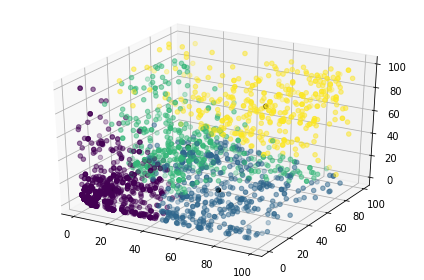


----- Clustering and plotting for: TruncatedSVD -----



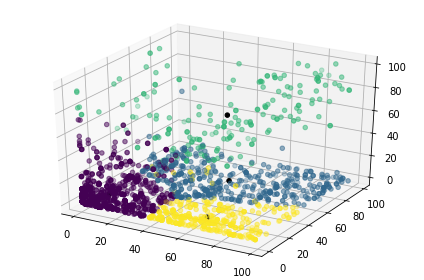

In [ ]:
for data, method in [(top_threes_pca, "PCA"), (top_threes_tsvd, "TruncatedSVD")]:
  print(f"\n----- Clustering and plotting for: {method} -----\n")
  clusters, centers = cluster_documents(data)
  # clusters, centers = ???
  plot_clusters(data, clusters, centers)
  # plot_clusters(???, ???, ???)
  

#### Checkpoint 3:

Show the TA your code! What do you think makes the difference in the distribution of the samples in the two plots above?

### Other applications of Dimensionality Reduction

Dimensionality Reduction has many great applications!

#### **Recommender Systems**

How do Netflix and Amazon recommend new movies or products to their users?

Matrix factorization gained a lot of visibility after the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize), where Simon Funk used this technique to solve the challenge of creating a better recommendation system for Netflix. The recommender system problem takes in a U x I matrix (called `A`) where each row `i` represents a user, each column `j` represents a movie, and the value `A[i, j]` represents the rating that the user `i` gave to the movie `j`.

Instead of using Singular Value Decomposition or Eigenvalue Decomposition to decompose the original matrix `A` into three different matrices, recommender systems generally factorize `A` into only two matrices, `A = U x T`, and there are multiple ways to approximate these `U` and `T` matrices, namely: Stochastic Gradient Descent, Gradient Descent, Least-Squared Errors calculation.

#### **Identifying Important Features in Images**

Interested in how dimensionality reduction can be used to identify important features in images? Check out the [previous iteration of this lab](https://cs1951a-s20-brown.github.io/labs/index.html).



### Credit

Made by Nam (ndo3) in Summer 2021, adapted from previous content with contribution from Alex Jang and Maggie Wu.